# Cluster Analytics for Optimal Workspace Convergence

## Imports

In [1]:
from sklearn.cluster import AffinityPropagation
import matplotlib.pyplot as plt
from itertools import cycle
from pathlib import Path
import tensorflow as tf
import pandas as pd
import requests
import os

## const

In [2]:
BASE_DIR = Path(os.getcwd()).resolve().parents[0]

## Dataset Preprocessing

So far, we have initialized path variables and imported necessary packages to run our cluster analysis. We will further optimize the dataset, add additionally information using Google Maps' Distrance Matrix API and run the AffinityPropagation model to obtain the ideal location for a workspace.

In [3]:
df = pd.read_csv(str(BASE_DIR) + "/data/raw/xtern.csv")

In [4]:
print(df.head())

                   Name                                            Address  \
0                 IUPUI        415 Porto Alegre St, Indianapolis, IN 46202   
1        The Speak Easy     5255 Winthrop Ave #110, Indianapolis, IN 46220   
2                zWORKS          85 E Cedar St #1502, Zionsville, IN 46077   
3        Launch Fishers             12175 Visionary Way, Fishers, IN 46038   
4  Industrious Mass Ave  350 Massachusetts Ave Suite 300, Indianapolis,...   

        Type  
0    Housing  
1  Coworking  
2  Coworking  
3  Coworking  
4  Coworking  


In [5]:
origin = df['Address'][0]
df = df.drop("Type", axis=1).drop(0).drop([6, 7, 8])

In [6]:
df.head()

,Name,Address
1,The Speak Easy,"5255 Winthrop Ave #110, Indianapolis, IN 46220"
2,zWORKS,"85 E Cedar St #1502, Zionsville, IN 46077"
3,Launch Fishers,"12175 Visionary Way, Fishers, IN 46038"
4,Industrious Mass Ave,"350 Massachusetts Ave Suite 300, Indianapolis,..."
5,Launch Indy,"525 S Meridian St, Indianapolis, IN 46225"


In [7]:
MAPS_API_KEY = input("enter the maps api key: ")
res = [] 
for i in df['Address']:
    url = f"https://maps.googleapis.com/maps/api/distancematrix/json?origins={origin.replace(' ', '+')}&destinations={i.replace(' ', '+')}&key={MAPS_API_KEY}"
    response = requests.request("GET", url, headers=headers, data=payload)
    
    res.append(response.json()["rows"][0]["elements"][0]["duration_in_traffic"]["value"]) 
df['Housing'] = np.array(res)

enter the maps api key: 


The output from the above cell is intentionally hidden in order to preserve API key secrecy.

In [11]:
df.head() 

,Name,Address,Housing
1,The Speak Easy,"5255 Winthrop Ave #110, Indianapolis, IN 46220",1020
2,zWORKS,"85 E Cedar St #1502, Zionsville, IN 46077",1500
3,Launch Fishers,"12175 Visionary Way, Fishers, IN 46038",1740
4,Industrious Mass Ave,"350 Massachusetts Ave Suite 300, Indianapolis,...",420
5,Launch Indy,"525 S Meridian St, Indianapolis, IN 46225",480


In [13]:
## A smaller number represents higher incentive
def cost_incentive(xi, xmax):
    res = xi / xmax 
    if (res < 0.2 or res > 0.8):
        return res + 0.4
    else:
        return res

We define the `cost_incentive` function to map a bell-curve of user incentive to attend an event based on its price. Since values are StandardScaled between [0 -> 1], we add a weight of `0.4` if values exceed hardcoded defined thresholds. 

We crucially define the bell curve for events with a low cost because individuals perceive value with cost - something that is too cheap may be interpreted as not something worth their time, and they are less incentvised to attend the event.

In [53]:
## Eventbrite's Location Search API was deprecated as of Dec 2019.
# Therefore, temporarily hardcoded information for events around Indianapolis :/

# Address, Frequency, Cost, Event, Date
events = [["Taps and Dolls, 247 S Meridian St, Indianapolis, IN 46225", 1, 10, "Illusions The Drag Queen Show Indianapolis - Drag Queen Dinner Show", "05-07-2022"],
         ["Sullivan's Steakhouse, 3316 E 86th St, Indianapolis, IN 46240", 1, 0, "Hippie Fest", "05-28-2022"],
         ["3009 Forest Manor Ave, Indianapolis, IN 46218", 1, 0, "One Team Scavenger Hunt Indianapolis", "05-01-2022"],
         ["The Vogue, 6259 N College Ave, Indianapolis, IN 46220", 1, 30, "Lari Pati", "05-11-2022"],
         ["The Vogue, 6259 N College Ave, Indianapolis, IN 46220", 1, 30, "Red Not Chilli Peppers", "05-17-2022"],
         ["Paramount Cottage Home, 1203 E St Clair St, Indianapolis, IN 46202", 1, 125, "Coffee with the Curator 2022", "05-13-2022"],
         ["Nexus Impact Center, second floor, west entrance, 9511 Angola Ct UNIT 200, Indianapolis, IN 46268", 1, 0, "Eric Johnson Treasure Tour", "05-23-2022"],
         ["REI Central Park, 301 N Illinois St B, Indianapolis, IN 46204", 1, 20, "Emily Warrick and Music", "05-31-2022"],
         ["2550 Hadley Grove S Dr, Carmel, IN 46074", 1, 98, "Big Data and Hadoop Training", "06-14-2022"], 
         ["Indianapolis Motor Speedway, Indianapolis, IN", 1, 175, "Indianapolis Racing Award Ceremony", "06-22-2022"],
         ["A Cut Above | Catering | Classes | Events, 12955 Old Meridian St UNIT 104, Carmel, IN 46032", 1, 100, "Pottery Class", "06-28-2022"]]

In [54]:
pd.DataFrame(events)

,0,1,2,3,4
0,"Taps and Dolls, 247 S Meridian St, Indianapoli...",1,10,Illusions The Drag Queen Show Indianapolis - D...,05-07-2022
1,"Sullivan's Steakhouse, 3316 E 86th St, Indiana...",1,0,Hippie Fest,05-28-2022
2,"3009 Forest Manor Ave, Indianapolis, IN 46218",1,0,One Team Scavenger Hunt Indianapolis,05-01-2022
3,"The Vogue, 6259 N College Ave, Indianapolis, I...",1,30,Lari Pati,05-11-2022
4,"The Vogue, 6259 N College Ave, Indianapolis, I...",1,30,Red Not Chilli Peppers,05-17-2022
5,"Paramount Cottage Home, 1203 E St Clair St, In...",1,125,Coffee with the Curator 2022,05-13-2022
6,"Nexus Impact Center, second floor, west entran...",1,0,Eric Johnson Treasure Tour,05-23-2022
7,"REI Central Park, 301 N Illinois St B, Indiana...",1,20,Emily Warrick and Music,05-31-2022
8,"2550 Hadley Grove S Dr, Carmel, IN 46074",1,98,Big Data and Hadoop Training,06-14-2022
9,"Indianapolis Motor Speedway, Indianapolis, IN",1,175,Indianapolis Racing Award Ceremony,06-22-2022


The above cell presents the sample 10-week activities plan for potential events to attend during the internship period.

In [ ]:
res = [] 
for enum, i in enumerate(events):
    for j in df['Address']:
        url = f"https://maps.googleapis.com/maps/api/distancematrix/json?origins={j.replace(' ', '+')}&destinations={i[0].replace(' ', '+')}&key={MAPS_API_KEY}"
        response = requests.request("GET", url, headers=headers, data=payload)
        score = response.json()["rows"][0]["elements"][0]["duration_in_traffic"]["value"] * ((70 - i[1]) / 70) * cost_incentive(i[2], 175)

        res.append(score)
    df[f'EVENT_{enum}'] = np.array(res)

The output from the above cell is intentionally hidden in order to preserve API key secrecy.

In [36]:
t = []
for j in df[f'Housing']:
    t.append(j * (20 / 70))
df[f'Housing'] = np.array(t)

The scores are computed as a function of the `cost_incentive` as previously described as well as the frequency within which the trip is made. Therefore, housing is given a greater weightage than any of the events, as they are singular instances, while travelling from home to work is recurring.

In [37]:
df.head()

,Name,Address,Housing,EVENT_0,EVENT_1,EVENT_2,EVENT_3,EVENT_4,EVENT_5,EVENT_6,EVENT_7,EVENT_8,EVENT_9,EVENT_10
1,The Speak Easy,"5255 Winthrop Ave #110, Indianapolis, IN 46220",291.428571,405.551020,307.542857,236.571429,168.979592,168.979592,549.183673,449.485714,456.244898,695.52,1407.6,608.326531
2,zWORKS,"85 E Cedar St #1502, Zionsville, IN 46077",428.571429,757.028571,425.828571,686.057143,709.714286,709.714286,1225.102041,189.257143,821.240816,331.20,1821.6,540.734694
3,Launch Fishers,"12175 Visionary Way, Fishers, IN 46038",497.142857,757.028571,378.514286,520.457143,709.714286,709.714286,1098.367347,473.142857,821.240816,761.76,2732.4,709.714286
4,Industrious Mass Ave,"350 Massachusetts Ave Suite 300, Indianapolis,...",120.000000,108.146939,591.428571,260.228571,540.734694,540.734694,168.979592,520.457143,91.248980,960.48,910.8,912.489796
5,Launch Indy,"525 S Meridian St, Indianapolis, IN 46225",137.142857,27.036735,662.400000,331.200000,675.918367,675.918367,380.204082,567.771429,91.248980,1026.72,1076.4,1013.877551


In [56]:
df.to_csv(str(BASE_DIR) + '/data/processed/xtern.csv', index=False)

## Modelling

In [50]:
X = np.array(df.drop(["Name", "Address"], axis=1))
af = AffinityPropagation(preference=-50, random_state=0).fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 5


## Visualization

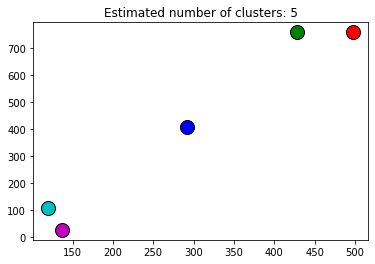

In [51]:
plt.close('all')
plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.plot(X[class_members, 0], X[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

The plotted points closest to the origin represent the optimal locations for co-working spaces. Reading the label map, Industrious Mass Ave is the ideal location for hosting the in-person workign environment.

## Model Saving

In [52]:
from joblib import dump, load
dump(af, 'affinity.joblib') ## saved in the models/ directory in the github repository!

['affinity.joblib']